# B regressor final training

## Import

### Import modules

In [8]:
from __future__ import division ,print_function

import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
import time
from keras import metrics , optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, GaussianNoise, BatchNormalization, Merge, Reshape
from keras.layers.advanced_activations import ELU, PReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras import backend as K


import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
from sklearn.pipeline import Pipeline
import json
import glob
import pickle
from sklearn.externals import joblib
import sys
sys.path.append('./../../modules')
from MPPlot import *
from Processors import *


### Import data
Here just looking at mu tau_h b b final-state

In [9]:
mode = "mu_tau_b_b"
loc = '../../../data_n/'
SignalData = []
BackgroundData = []

energies = ['260', '270', '280', '300', '320', '400', '500', '550', '600' ,'700']
backgrounds = ['TT' , 'WJetsToLNu']
Data = np.concatenate((energies,backgrounds))

def backgroundName(background):
    if background == 'TT':
        return loc + 'TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv'
    elif background == 'WJetsToLNu':
        return loc + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv'



 #Load data from CSV files
for energy in energies:
    signaldata = pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + str(energy) +"_narrow_13TeV-madgraph.csv")
    signaldata['gen_label'] = energy
    SignalData.append(signaldata)


for back in backgrounds:
    backgroundData = pandas.read_csv(backgroundName(back))
    backgroundData['gen_label'] = back
    BackgroundData.append(backgroundData)    
     
    
signalData = SignalData[0]
for signal_data in SignalData[1:]:
    signalData = signalData.append(signal_data, ignore_index=True)    
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)    
signalData['gen_target'] = pandas.Series(np.ones(signalData.size))
backgroundData = BackgroundData[0]
for background_data in BackgroundData[1:]:
    backgroundData = backgroundData.append(background_data, ignore_index=True)    
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)    
backgroundData['gen_target'] = pandas.Series(np.zeros(backgroundData.size))

print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset


def abs_(x):
    if type(x) is float:
        return abs(x)
    else:
        return x

def cleanData(X):
    """
    Recives data X
    Returns: X after removing points that would fail to convert to float32 
    """
    X.applymap(abs_)
    
    
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    
    X = X[np.logical_not(selecting)].reset_index(drop=True)
    
    return X

data = cleanData(data)

Samples contains 10417 signal events and 168053 background events
178470 events in total


### Process data and add new features

In [10]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH', 'gen_t_0', 'gen_t_1', 'gen_b_0' ,'gen_b_1']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    if(not str.startswith(p, "gen")):
        addEnergy(data, p) #Calculate energy and absolute momentum


moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))

In [11]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)

    
devData = data.loc[sig_devIndeces].copy()
#devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData)))


3928 events for training, 174533 events for validation


### Specify variables

In [12]:

genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]
print(*trainFeatures, sep=' , ')

t_0_pT , t_0_eta , t_0_phi , t_0_mass , t_1_pT , t_1_eta , t_1_phi , t_1_mass , b_0_pT , b_0_eta , b_0_phi , b_0_mass , b_0_csv , b_1_pT , b_1_eta , b_1_phi , b_1_mass , b_1_csv , mPT_pT , mPT_phi , h_tt_pT , h_tt_eta , h_tt_phi , h_tt_mass , h_tt_svFit_mass , h_bb_pT , h_bb_eta , h_bb_phi , h_bb_mass , diH_pT , diH_eta , diH_phi , diH_mass , diH_kinFit_mass , diH_kinFit_prob , mT , hT , sT , centrality , eVis , sphericity , spherocity , aplanarity , aplanority , upsilon , dShape , sphericityEigen0 , sphericityEigen1 , sphericityEigen2 , spherocityEigen0 , spherocityEigen1 , spherocityEigen2 , t_0_px , t_0_py , t_0_pz , t_0_|p| , t_0_E , t_1_px , t_1_py , t_1_pz , t_1_|p| , t_1_E , b_0_px , b_0_py , b_0_pz , b_0_|p| , b_0_E , b_1_px , b_1_py , b_1_pz , b_1_|p| , b_1_E , h_tt_px , h_tt_py , h_tt_pz , h_tt_|p| , h_tt_E , h_bb_px , h_bb_py , h_bb_pz , h_bb_|p| , h_bb_E , diH_px , diH_py , diH_pz , diH_|p| , diH_E , mPT_px , mPT_py , mPT_|p| , t_1_mT , hl_mT


In [13]:
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi'] if x in var]

other = [var for var in trainFeatures for x in ['Fit', 'csv'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi+ other]
print(trainFeatures)

['t_0_mass', 't_1_mass', 'b_0_mass', 'b_1_mass', 'h_tt_mass', 'h_bb_mass', 'diH_mass', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'sphericity', 'spherocity', 'aplanarity', 'aplanority', 'upsilon', 'dShape', 'sphericityEigen0', 'sphericityEigen1', 'sphericityEigen2', 'spherocityEigen0', 'spherocityEigen1', 'spherocityEigen2', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_mT']


In [14]:
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT','mT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_"))]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in shapeFeatures + pTEtaPhi + hlFeatures + recoFeatures ]

In [50]:
finalFeatures = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi] + ['hl_mT']
#finalFeatures = ['diH_mass']

## Specify options

In [51]:
ganTrainFeatures = finalFeatures
normIn = True
pca = True
whiten = False
nSplits = 10
cvTests = True
ensembleSize = 10
ensembleMode = 'loss'


In [72]:
def getGenerator(nOut):
    classModel = Sequential()
    depth = 4
    width = 100
    classModel.add(Dense(width, input_dim=150, kernel_initializer='glorot_normal', activation='tanh')) #First layer requires number of inputs
    classModel.add(Dropout(0.2))
    for i in range(depth): #Continue to add hidden layers
        classModel.add(Dense(width, kernel_initializer='glorot_normal', activation='selu')) #Subsequent layers inherit input_dim from previous layer 
       # width = width*2
        classModel.add(Dropout(0.2))          
    classModel.add(Dense(nOut, activation='linear')) 
    
    
    return classModel

def getDiscriminator(nIn):
    classModel = Sequential()
    depth = 4
    width = 100
    classModel.add(Dense(nIn, input_dim=nIn, kernel_initializer='glorot_normal', activation='tanh')) #First layer requires number of inputs
    classModel.add(Dropout(0.2))
 
    for i in range(depth): #Continue to add hidden layers
        classModel.add(Dense(width, kernel_initializer='glorot_normal', activation='selu')) #Subsequent layers inherit input_dim from previous layer 
      #  width = width//2
        classModel.add(Dropout(0.2))
          
    classModel.add(Dense(1, activation='sigmoid')) #Final layer requires one output    
    
    
    return classModel
G = getGenerator(len(finalFeatures))
G.compile(loss = 'mse', optimizer = 'nadam' , metrics = ['acc']) #Compile the network graph to prepare it for use
D.trainable=True
D = getDiscriminator(len(finalFeatures))
D.compile(loss = 'binary_crossentropy', optimizer = 'nadam' , metrics = ['acc']) #Compile the network graph to prepare it for use

z = Input(shape=(150,))
x = G(z)
D.trainable = False
A = D(x) 
C = Model(z,A)
C.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['acc']) #Compile the network graph to prepare it for use

G.summary()
D.summary()
C.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 100)               15100     
_________________________________________________________________
dropout_86 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 100)               10100     
_________________________________________________________________
dropout_87 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_132 (Dense)            (None, 100)               10100     
_________________________________________________________________
dropout_88 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_133 (Dense)            (None, 100)               10100     
__________

### Preprocess data

In [64]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
inputPipe = Pipeline(stepsIn)
stepsOut = []
stepsOut.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
outputPipe = Pipeline(stepsOut)


In [65]:
X_class = inputPipe.fit_transform(devData[finalFeatures].values.astype(theano.config.floatX))



### Train regressors
Train nSplit times to find best convergence

In [73]:
start = time.time()
results = []
histories = []
os.system("rm train_weights/*.h5")
os.system("rm train_weights/*.json")
os.system("rm train_weights/*.pkl")
"""for i in range(150): 
    fakeData = []
    fakeInput = np.random.normal(size=(len(devData),150))
    
    fakeData = G.predict(fakeInput)
    fakeData = pandas.DataFrame(data=fakeData,    # values
                 columns=finalFeatures)  # 1st row as the column names
    X_fake = inputPipe.fit_transform(fakeData.values.astype(theano.config.floatX))
    idx = np.random.randint(0, X_class.shape[0], 256)
    X_train = X_class[idx]
    X_fake = X_fake[idx]
    X_final = np.concatenate((X_train, X_fake), axis= 0)
   
    Y_final = np.concatenate((np.ones(X_train.shape[0]) , np.zeros(X_fake.shape[0])),axis= 0)
    loss = D.train_on_batch(X_final, Y_final)
    
    #loss = 0.5*np.add(loss_real,loss_fake)
    #print ("Real Loss:", loss_real[0] , " ", "Fake Loss:", loss_fake[0] , " ", "Mean Loss:", loss[0] , 'Mean acc', loss[1]*100, "\n")
    print(loss[1])"""
for i in range(1000):   
    fakeData = []
    fakeInput = np.random.normal(size=(len(devData),150))
    fakeData = G.predict(fakeInput)
    fakeData = pandas.DataFrame(data=fakeData,    # values
                 columns=finalFeatures)  # 1st row as the column names
    X_fake = inputPipe.fit_transform(fakeData.values.astype(theano.config.floatX))
    idx = np.random.randint(0, X_class.shape[0], 256)
    X_train = X_class[idx]
    X_fake = X_fake[idx]
    X_final = np.concatenate((X_train, X_fake), axis= 0)
    Y_final = np.concatenate((np.ones(X_train.shape[0]) , np.zeros(X_fake.shape[0])),axis= 0)
    loss = D.train_on_batch(X_final, Y_final)
    
    print ("Mean Loss:", loss[0] , 'Mean acc', loss[1]*100, "\n")
      
    fakeInput = np.random.normal(size=(len(devData),150))
    valid_y = np.array([1] * fakeInput.shape[0])
    bloss = D.evaluate(G.predict(fakeInput),np.zeros(fakeInput.shape[0]), verbose= 0)
    g_loss = C.train_on_batch(fakeInput, valid_y)
    aloss = D.evaluate(G.predict(fakeInput),np.zeros(fakeInput.shape[0]), verbose =0)
    print(g_loss[0], " ", g_loss[1]*100,  "\n" , aloss[1] , " ", bloss[1] )  
    
feature_n=9
sns.distplot(G.predict(np.random.normal(size=(100000,100)))[:,feature_n], label=finalFeatures[feature_n])
    
sns.distplot(Xtest[:,feature_n], label=finalFeatures[feature_n])
plt.show()       
with open('train_weights/resultsFile.pkl', 'wb') as fout: 
    pickle.dump(results, fout)
print ("Cross-validation took {:.3f}s ".format(time.time() - start))



Mean Loss: 0.858545362949 Mean acc 50.78125 

0.85474717617   53.5641551018 
 0.3383401222   0.459775967413
Mean Loss: 0.827075660229 Mean acc 53.3203125 

0.807601571083   52.3676156998 
 0.276731160866   0.386965376752
Mean Loss: 0.781613051891 Mean acc 52.1484375 

0.752733111382   56.4663946629 
 0.250509164909   0.320773930693
Mean Loss: 0.796015143394 Mean acc 54.296875 

0.754188239574   55.0661921501 
 0.170824847251   0.233961303493
Mean Loss: 0.814948797226 Mean acc 50.1953125 

0.753607332706   54.5824825764 
 0.135947046851   0.179226069262
Mean Loss: 0.756296873093 Mean acc 56.4453125 

0.745362401009   54.506111145 
 0.142566191461   0.181771894109
Mean Loss: 0.751407921314 Mean acc 53.3203125 

0.705183088779   58.0193459988 
 0.107179226039   0.135183299359
Mean Loss: 0.771111726761 Mean acc 50.5859375 

0.725789785385   56.0336053371 
 0.195264765723   0.224032586497
Mean Loss: 0.771021366119 Mean acc 53.90625 

0.75295650959   53.2841145992 
 0.268329938961   0.296334

KeyboardInterrupt: 

### Plot distributions 

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/an

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/an

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/an

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


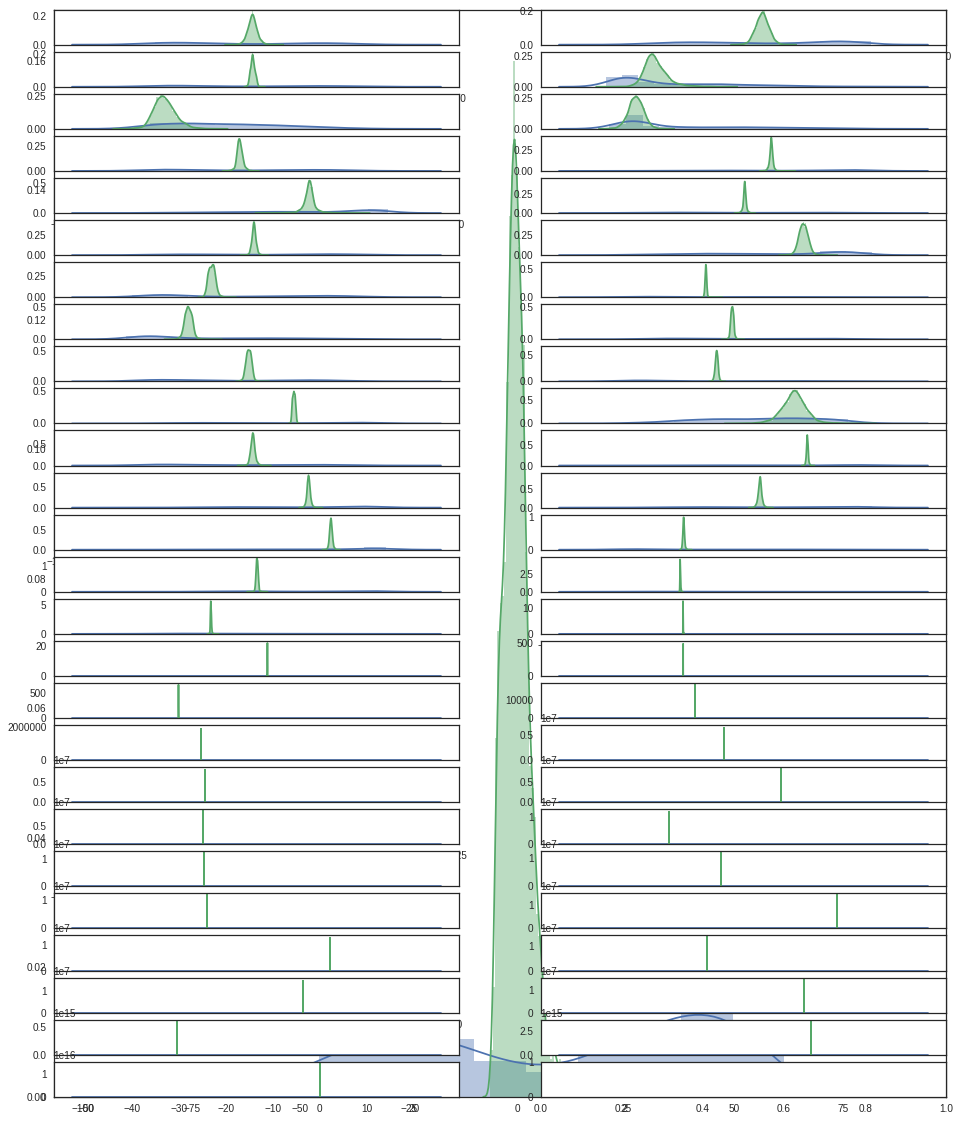

In [58]:
fig = plt.figure(figsize=(16,20))
for i in range(len(finalFeatures)):
    feature_n=i
    sns.distplot(G.predict(np.random.normal(size=(1000,150)))[:,feature_n], label=finalFeatures[feature_n])
    sns.distplot(X_class[:,feature_n], label=finalFeatures[feature_n])
    fig.add_subplot((len(finalFeatures)+1)//2,2,i+1)
plt.show()   

# Save

In [ ]:
name = "weights/NN_B_Regressor_App_" + mode + "_" 
print (name)

In [ ]:
# added 3 'b's (?) for some reason some need and other don't... don't get it
# i guess json as str and the others are bin

os.system("rm " + name + "*.json")
os.system("rm " + name + "*.h5")
os.system("rm " + name + "*.pkl")
for i, model in enumerate(ensemble):
    json_string = model.to_json()
    open(name + '_' + str(i) + '.json', 'w').write(json_string) 
    model.save_weights(name + '_' + str(i) + '.h5')
with open(name + '_compile.json', 'w') as fout:
    json.dump(compileArgs, fout)
with open(name + '_weights.pkl', 'wb') as fout:
    pickle.dump(weights, fout)
with open(name + '_inputPipe.pkl', 'wb') as fout:
    pickle.dump(inputPipe, fout)
with open(name + '_outputPipe.pkl', 'wb') as fout:
    pickle.dump(outputPipe, fout)

## Response of ensemble on development data

## Load

In [ ]:
ensemble = []
weights = None
inputPipe = None
outputPipe = None
compileArgs = None
with open(name + '_compile.json', 'r') as fin:
    compileArgs = json.load(fin)
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name + "_" + str(i) + '.h5')
    model.compile(**compileArgs)
    ensemble.append(model)
with open(name + '_weights.pkl', 'rb') as fin:
    weights = pickle.load(fin)
with open(name + '_inputPipe.pkl', 'rb') as fin:
    inputPipe = pickle.load(fin)
with open(name + '_outputPipe.pkl', 'rb') as fin:
    outputPipe = pickle.load(fin)